In [1]:
%load_ext autoreload
%autoreload 2
import os
import pathlib

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
os.environ["BART_TOOLBOX_PATH"] = "/Users/chunxuguo/bart"

import torch
import torchopt
from einops import rearrange, reduce
from fastmri import complex_abs
from fastmri.data import mri_data, subsample, transforms

from ese5934_project.datasets.csm_estimation import espirit_csm_estimation
from ese5934_project.models.operators import ForwardModel, MaskedForwardModel
from ese5934_project.tasks.mri_reconstruction_2d import reconstruct

# Create a mask function
mask_func = subsample.RandomMaskFunc(center_fractions=[0.08], accelerations=[4])


def data_transform(kspace, mask, target, data_attributes, filename, slice_num):
    # Transform the data into appropriate format
    # Here we simply mask the k-space and return the result
    kspace = transforms.to_tensor(kspace * 1e5)
    mean = reduce(kspace, "ch h w complex-> () () complex", "mean")
    std = reduce(kspace, "ch h w complex-> () () complex", torch.std)
    print(mean, std)
    print(mean.shape, std.shape)
    masked_kspace, mask, num_low_frequencies = transforms.apply_mask(kspace, mask_func)
    csm = transforms.to_tensor(espirit_csm_estimation(kspace, num_low_frequencies))
    # kspace = kspace
    # masked_kspace = masked_kspace
    # csm = csm
    # mask = rearrange(mask, "() () w ()-> () () w")
    csm = rearrange(csm, "() h w ch complex-> ch h w complex")
    return kspace, (mean, std), masked_kspace, mask, csm


dataset = mri_data.SliceDataset(
    root=pathlib.Path("/Users/chunxuguo/ese5934_project/data"),
    transform=data_transform,
    challenge="multicoil",
)

[2024-02-15 15:34:42,264] torch.distributed.elastic.multiprocessing.redirects: [WARNING] NOTE: Redirects are currently not supported in Windows or MacOs.


# Grid Field (Voxel Representation)

In [22]:
from ese5934_project.models.GridField import Grid

optimizer = torchopt.adam(lr=0.001)
kspace, (mean, std), masked_kspace, mask, csm = dataset[15]
field = Grid((640, 368), mean, std)

python(48298) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Done.


In [ ]:
print(masked_kspace.shape, mask.shape, csm.shape)

In [6]:
params, image_list = reconstruct(
    field,
    torch.rand(1, 2),
    masked_kspace,
    csm,
    mask,
    optimizer=optimizer,
    iterations=200,
    device=torch.device("mps"),
)

iteration 1, loss: 0.0011084506986662745
iteration 2, loss: 0.20276296138763428
iteration 3, loss: 0.013381535187363625
iteration 4, loss: 0.044270891696214676
iteration 5, loss: 0.11586011946201324
iteration 6, loss: 0.08364998549222946
iteration 7, loss: 0.021141286939382553
iteration 8, loss: 0.0014303281204774976
iteration 9, loss: 0.029668185859918594
iteration 10, loss: 0.05672051012516022
iteration 11, loss: 0.049642279744148254
iteration 12, loss: 0.021677490323781967
iteration 13, loss: 0.0024766603019088507
iteration 14, loss: 0.006339809857308865
iteration 15, loss: 0.022433355450630188
iteration 16, loss: 0.030351584777235985
iteration 17, loss: 0.022597357630729675
iteration 18, loss: 0.008582262322306633
iteration 19, loss: 0.0015756580978631973
iteration 20, loss: 0.005609204061329365
iteration 21, loss: 0.013487718068063259
iteration 22, loss: 0.015842515975236893
iteration 23, loss: 0.010701170191168785
iteration 24, loss: 0.0038123968988656998
iteration 25, loss: 0.00

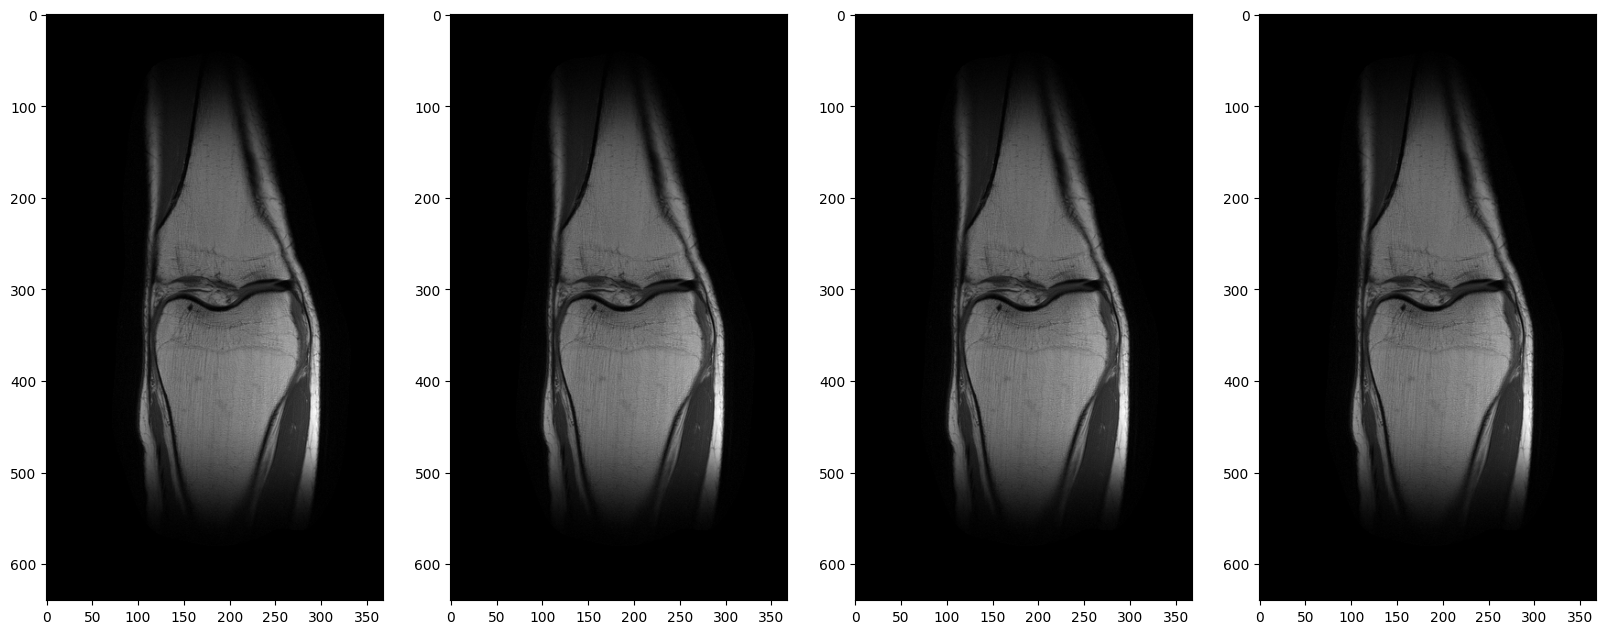

In [7]:
import matplotlib.pyplot as plt

# there are 20 images in the list,
# we want to plot them in a grid of 4x5
fig, axs = plt.subplots(1, 4, figsize=(20, 10))
for i, image in enumerate(image_list):
    axs[i % 5].imshow(complex_abs(image), cmap="gray")

# SIREN

In [2]:
from ese5934_project.models.SIREN import Siren, get_coordinates

device = torch.device("mps")
size = (640, 368)
coords = get_coordinates(size)
kspace, (mean, std), masked_kspace, mask, csm = dataset[15]
field = Siren(
    size,
    mean.to(device),
    std.to(device),
    in_features=2,
    out_features=2,
    hidden_features=128,
    hidden_layers=3,
    outermost_linear=True,
)
optimizer = torchopt.adamw(lr=1e-3)
# 1e-4 1.092077389
# 1e-3 0.08540542

/Users/chunxuguo/Library/Caches/pypoetry/virtualenvs/ese5934-project-3rfU7kGt-py3.11/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])
Done.


In [3]:
params, image_list = reconstruct(
    field,
    coords,
    masked_kspace,
    csm,
    mask,
    optimizer=optimizer,
    iterations=1000,
    device=device,
)

/Users/chunxuguo/Library/Caches/pypoetry/virtualenvs/ese5934-project-3rfU7kGt-py3.11/lib/python3.11/site-packages/fastmri/fftc.py:32: UserWarning: The operator 'aten::_fft_c2c' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  torch.fft.fftn(  # type: ignore


iteration 1, loss: 2.9696295261383057
iteration 2, loss: 2.9141128063201904
iteration 3, loss: 2.8599624633789062
iteration 4, loss: 2.880645751953125
iteration 5, loss: 2.797536611557007
iteration 6, loss: 2.742372989654541
iteration 7, loss: 2.700054883956909
iteration 8, loss: 2.644160270690918
iteration 9, loss: 2.598114013671875
iteration 10, loss: 2.541302442550659
iteration 11, loss: 2.4896275997161865
iteration 12, loss: 2.435879707336426
iteration 13, loss: 2.38010573387146
iteration 14, loss: 2.3253822326660156
iteration 15, loss: 2.271174907684326
iteration 16, loss: 2.215674638748169
iteration 17, loss: 2.1620476245880127
iteration 18, loss: 2.11082124710083
iteration 19, loss: 2.0638585090637207
iteration 20, loss: 2.020956039428711
iteration 21, loss: 1.9760079383850098
iteration 22, loss: 1.9195705652236938
iteration 23, loss: 1.8643555641174316
iteration 24, loss: 1.823379397392273
iteration 25, loss: 1.7797906398773193
iteration 26, loss: 1.7307530641555786
iteration 2

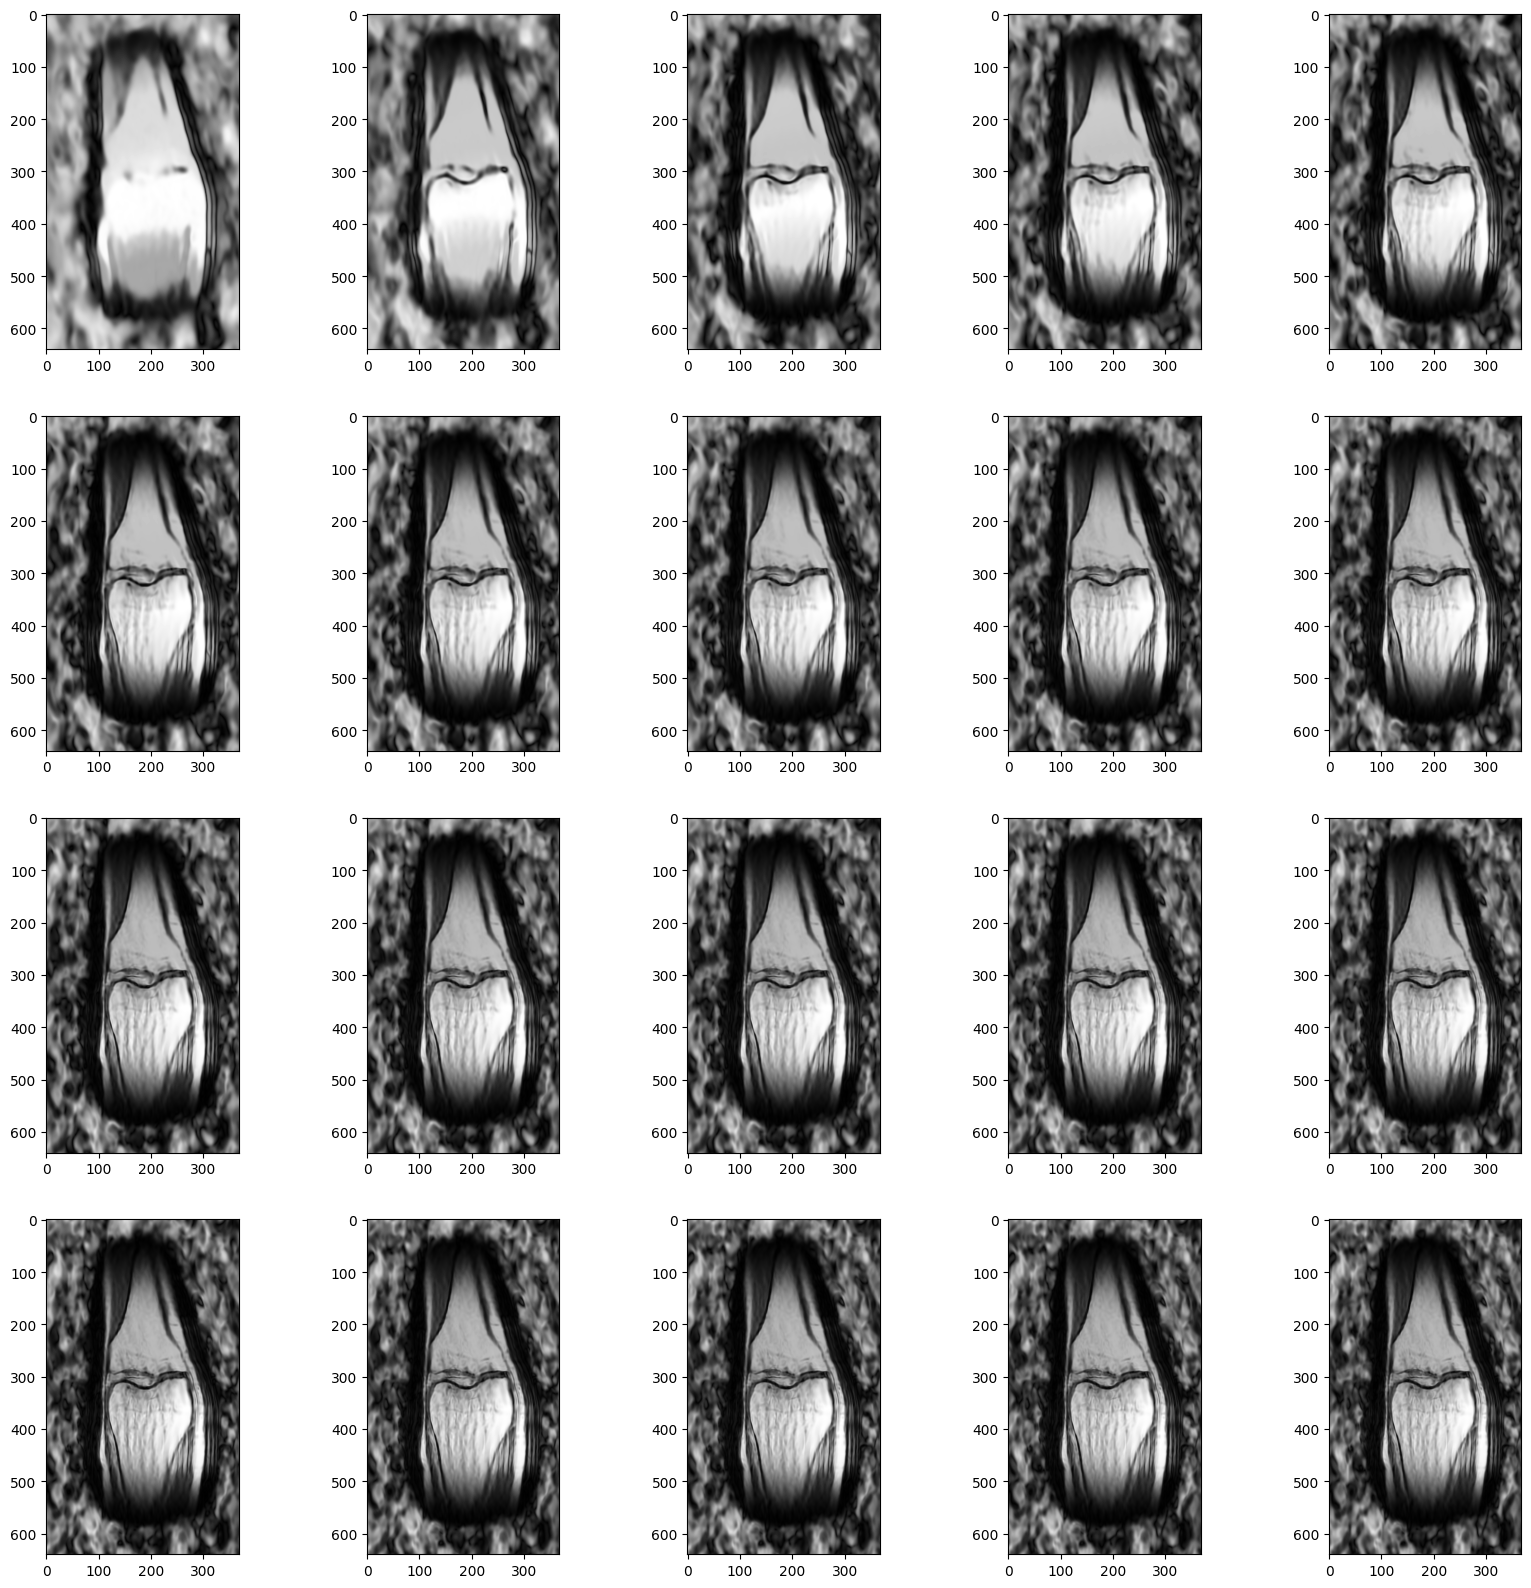

In [5]:
import matplotlib.pyplot as plt

# there are 20 images in the list,
# we want to plot them in a grid of 4x5
fig, axs = plt.subplots(4, 5, figsize=(20, 20))
for i, image in enumerate(image_list):
    axs[i // 5, i % 5].imshow(complex_abs(image), cmap="gray")